In [ ]:
from src.res.factor.calculator.hierarchy import StockFactorHierarchy
import pandas as pd

factor_table = StockFactorHierarchy.load_factor_table()

sub_factors : list[str] = StockFactorHierarchy.get_factor('event_factor_momentum').sub_factors
data = [(x.removeprefix('-') , -1 if x.startswith('-') else 1) for x in sub_factors]
df = pd.DataFrame(data , columns = ['factor_name' , 'sign'])
df.merge(factor_table.loc[:,['factor_name' , 'daily_ic' , 'weekly_ic' , 'weekly_long']] , on = 'factor_name' , how = 'left')

,factor_name,sign,daily_ic,weekly_ic,weekly_long
0,risk_lncap,-1,-0.020860,-0.038294,-0.003787
1,risk_beta,1,0.002650,-0.003324,0.000861
2,btop,1,-0.004517,-0.000544,-0.000921
3,etop,1,0.003760,0.007339,-0.000111
4,stop,1,-0.000858,0.003602,-0.000347
5,etop_est,1,-0.002179,0.001480,-0.000846
6,epg_est,1,0.002008,0.002606,-0.000014
7,sales_yoy,1,0.007225,0.010545,0.000514
8,npro_yoy,1,0.008219,0.011991,0.001363
9,sue_npro,1,0.008797,0.012629,0.001006


In [2]:
from src.proj import SharedSync
from src.basic import TaskScheduler
SharedSync.sync()

script = "2_research/training/2_schedule_model.py"
kwargs = {
    'email' : True,
    'schedule_name' : 'xgb_of_factors_long_20',
    'short_test' : None,
    'resume' : False
}
TaskScheduler.add_run_script(script , kwargs)

add run script /home/mengkjin/workspace/learndl/src/scripts/2_research/training/2_schedule_model.py with kwargs {'email': True, 'schedule_name': 'xgb_of_factors_long_20', 'short_test': None, 'resume': False} to mengkjin-server
ScheduledTask /Users/mengkjin/workspace/share/onedrive/task_schedule/mengkjin-server/20251012012838.00.await distributed


In [5]:
class A:
    def __init__(self , a : int):
        self.a = a
class B(A):
    def __init__(self , b : int):
        self.b = b

issubclass(B , A)



True

In [4]:
a = {2:1 , 1:2}

sorted(a.items() , key = lambda x: x[0])

[(1, 2), (2, 1)]

In [1]:
from src.data.download.tushare.basic.fetcher import TushareFetcher

TushareFetcher.load_tasks()
TushareFetcher.registry['DailyQuote']().last_date()

src.basic.INSTANCE_RECORD can be accessed to check ['trainer', 'account', 'factor']
main path: /Users/mengkjin/workspace/learndl
Use MPS as default device


20250418

In [ ]:
from src.res.trading.util import TradingPort
from src.basic import CALENDAR

date = CALENDAR.updated()
tradeport_names = ['event_factor_momentum.backtest' , 'event_factor_momentum.backtest1' , 'event_factor_momentum.backtest2' , 'event_factor_momentum.backtest3']
for name in tradeport_names:
    tp = TradingPort.load(name)
    tp.build(date).analyze()



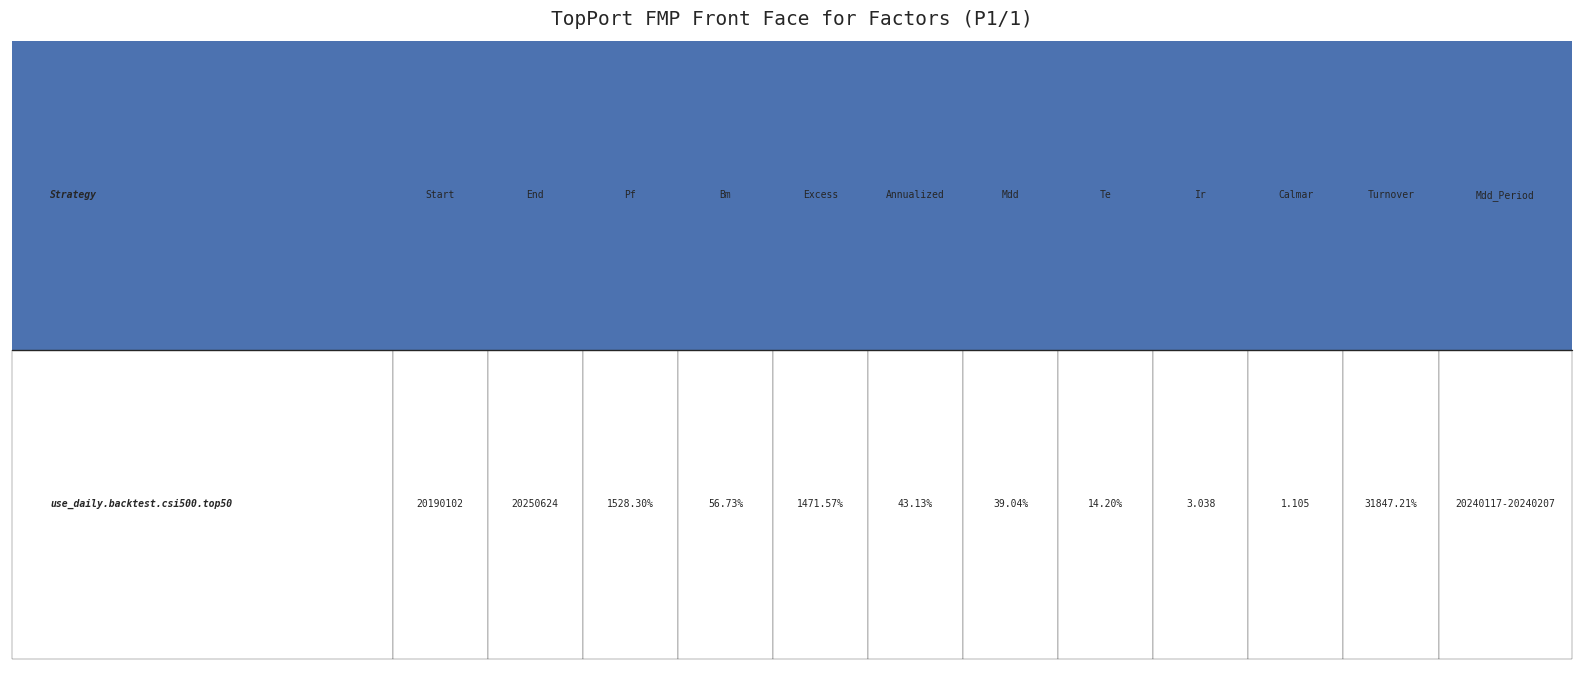

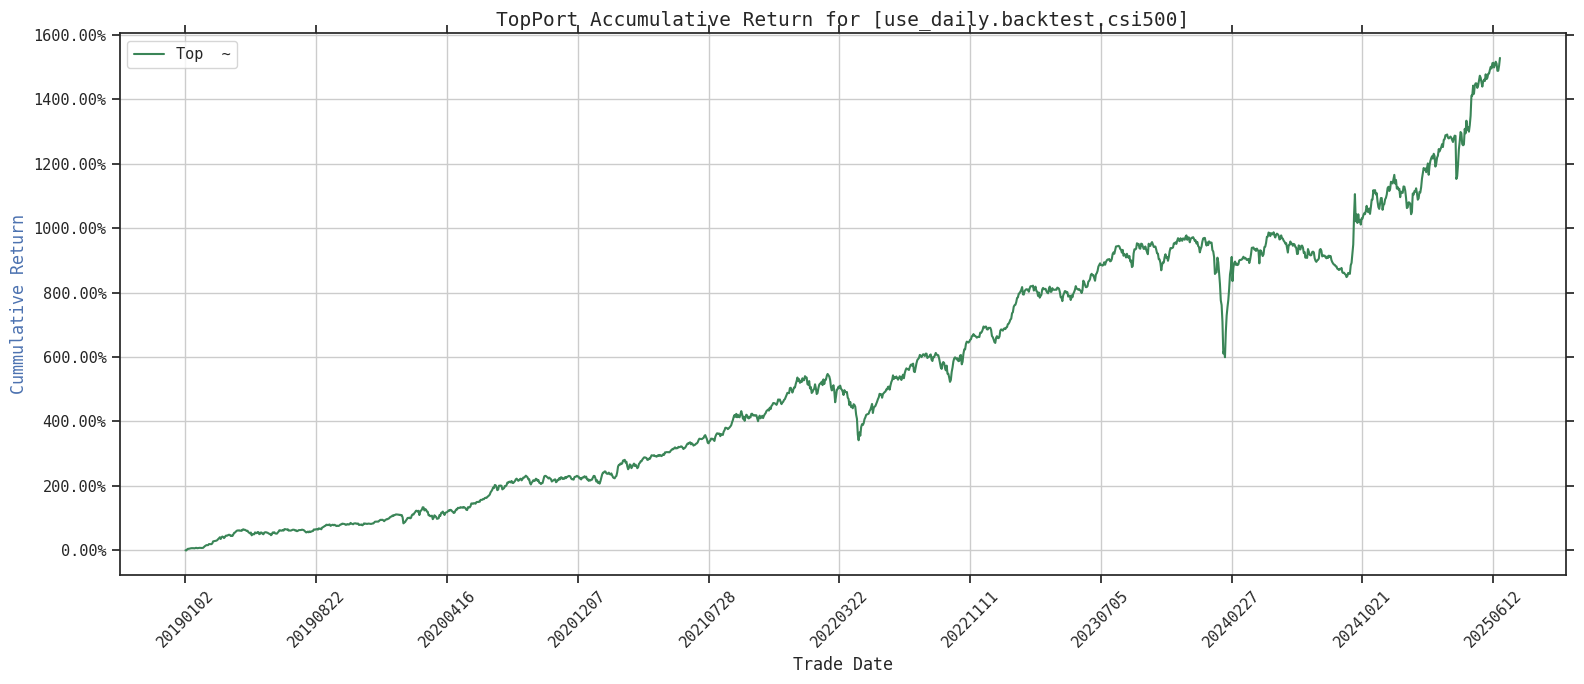

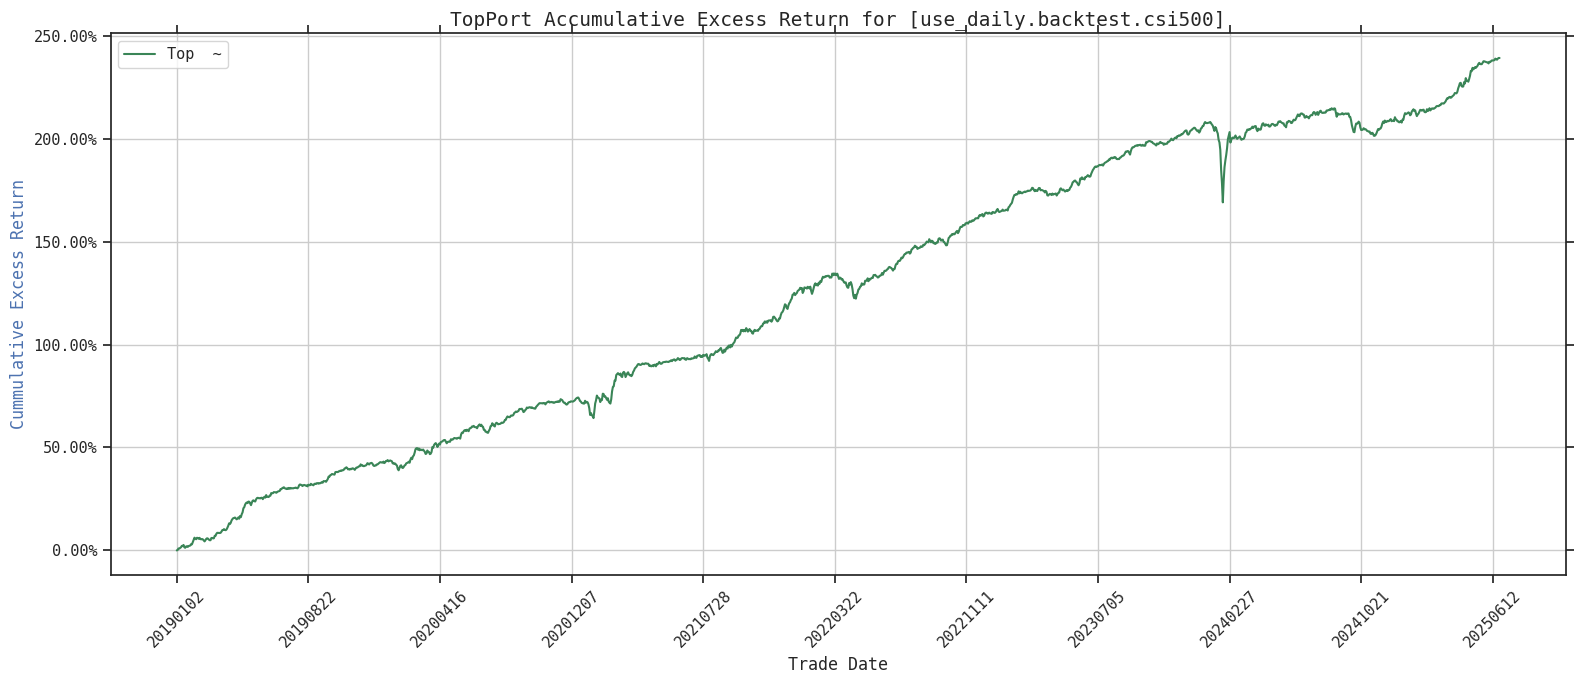

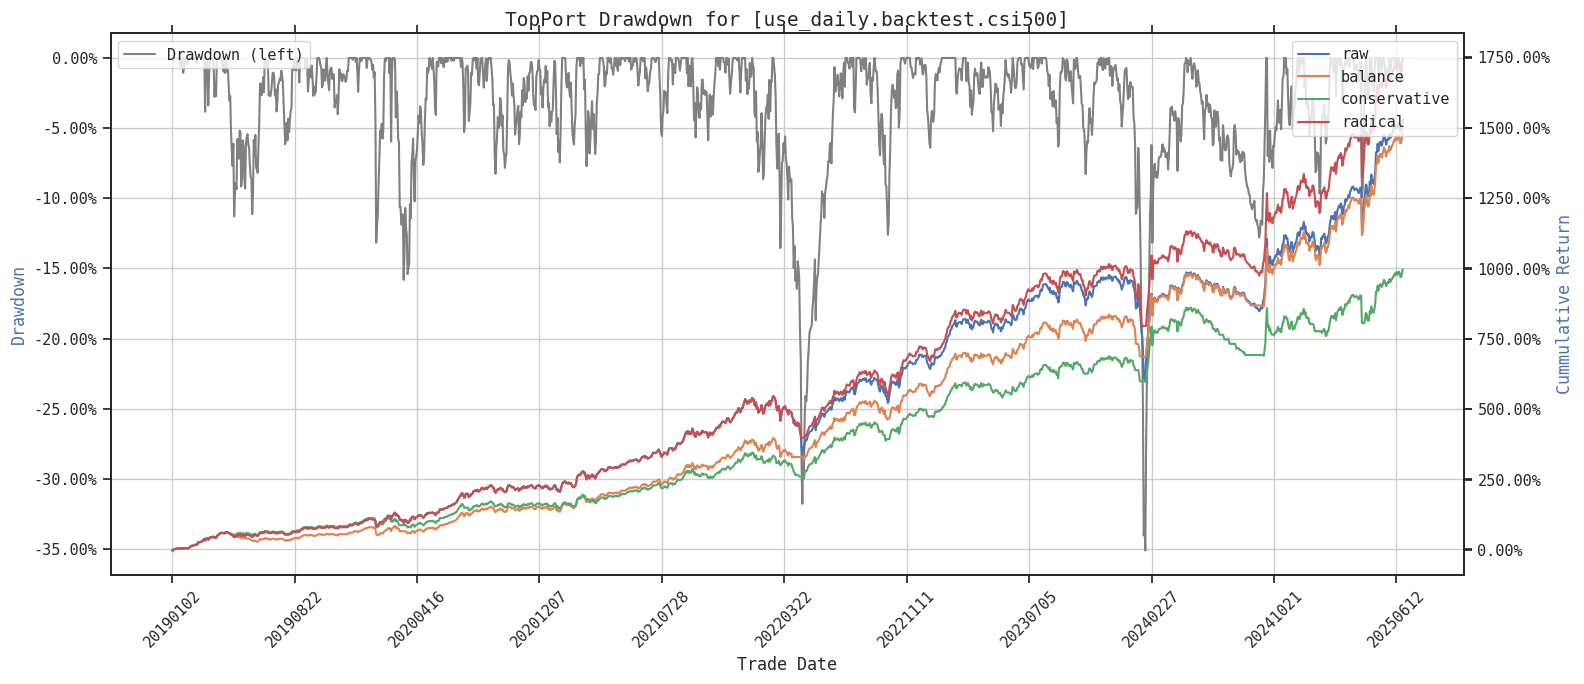

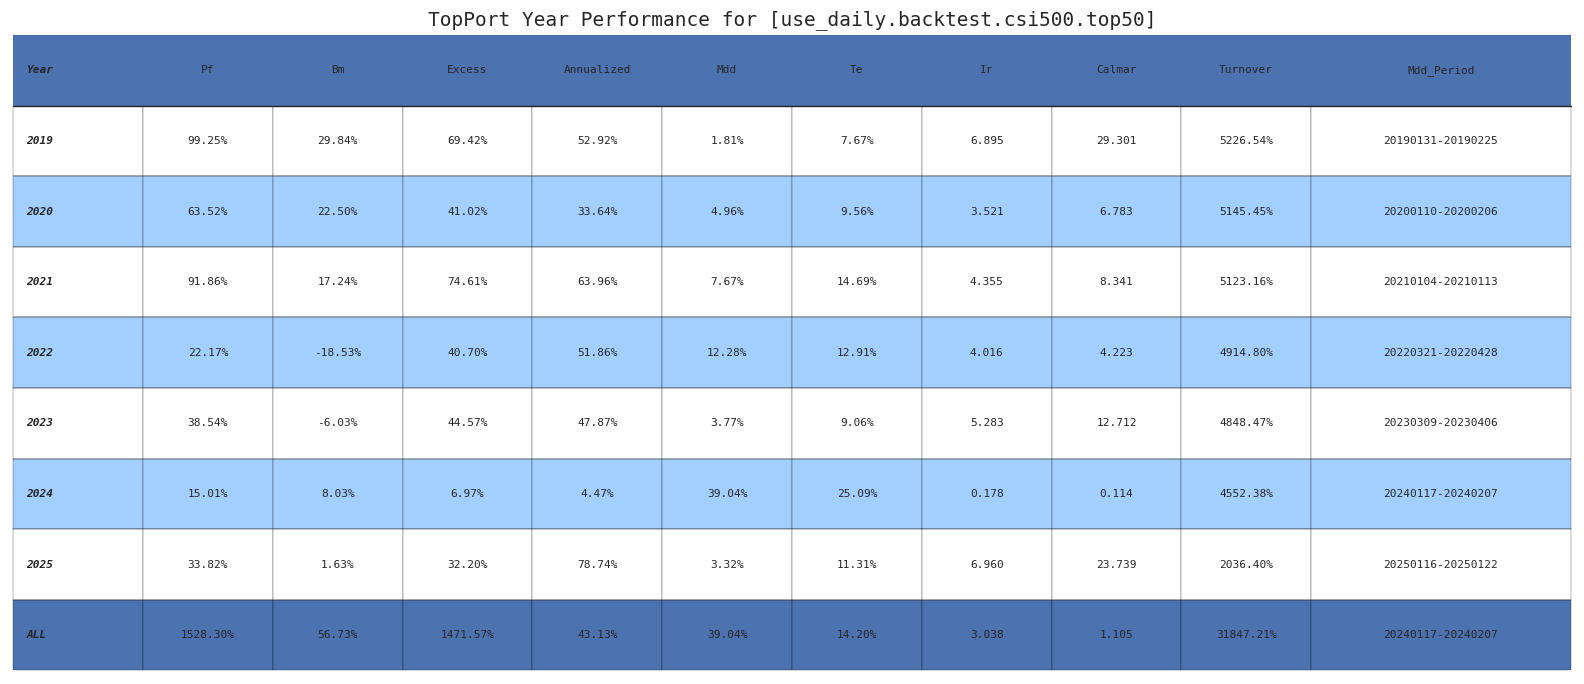

use_daily.backtest analyze Finished!


TradingPort(name='use_daily.backtest', alpha='big_combine', universe='top-1000', components=['sellside@huatai.master_combined@master_combined', 'sellside@dongfang.scores_v0@avg', 'gru_day_V1'], weights=[1.0, 1.0, 1.0], top_num=50, freq=1, init_value=1000000.0, backtest=True, test_start=20190101, test_end=20991231, benchmark='csi500', buffer_zone=0.8, no_zone=0.5, indus_control=0.1)

In [ ]:
from src.res.trading.util import TradingPort
tp = TradingPort.load('use_daily.backtest')
tp.build(20250624).analyze()

main path: /home/mengkjin/workspace/learndl
Use device name: NVIDIA GeForce RTX 4090
src.INSTANCE_RECORD can be accessed to check ['trainer', 'account', 'factor']
Perform backtest for TradingPort use_daily.backtest2 , 1569 days


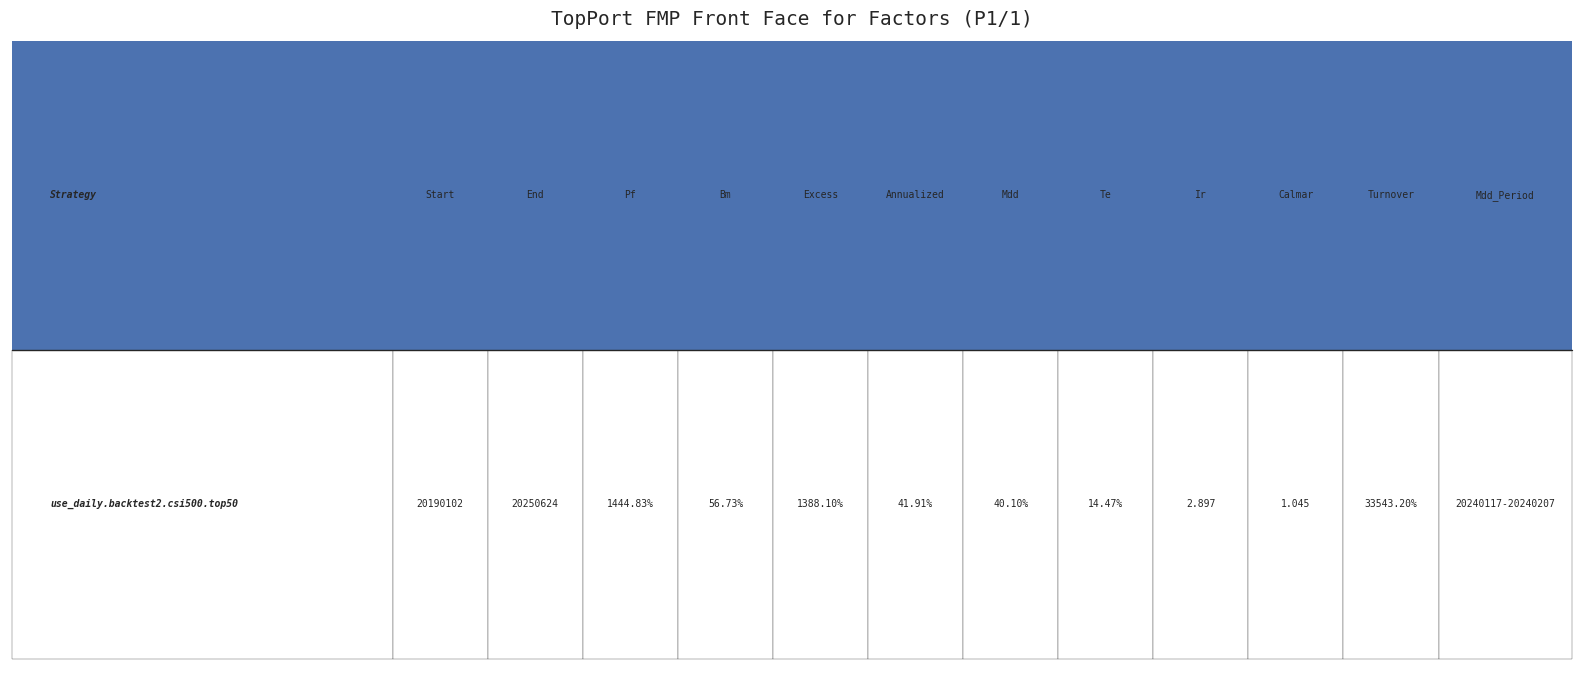

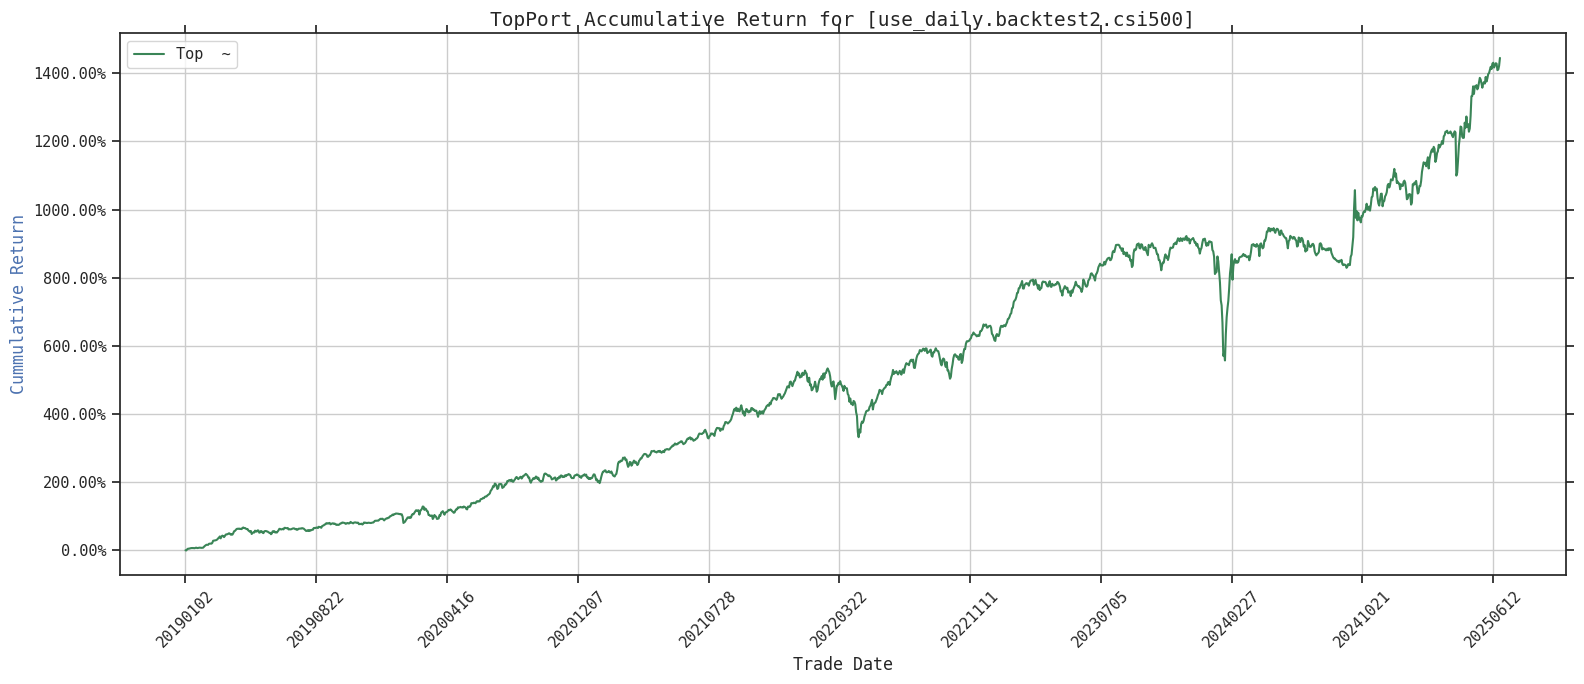

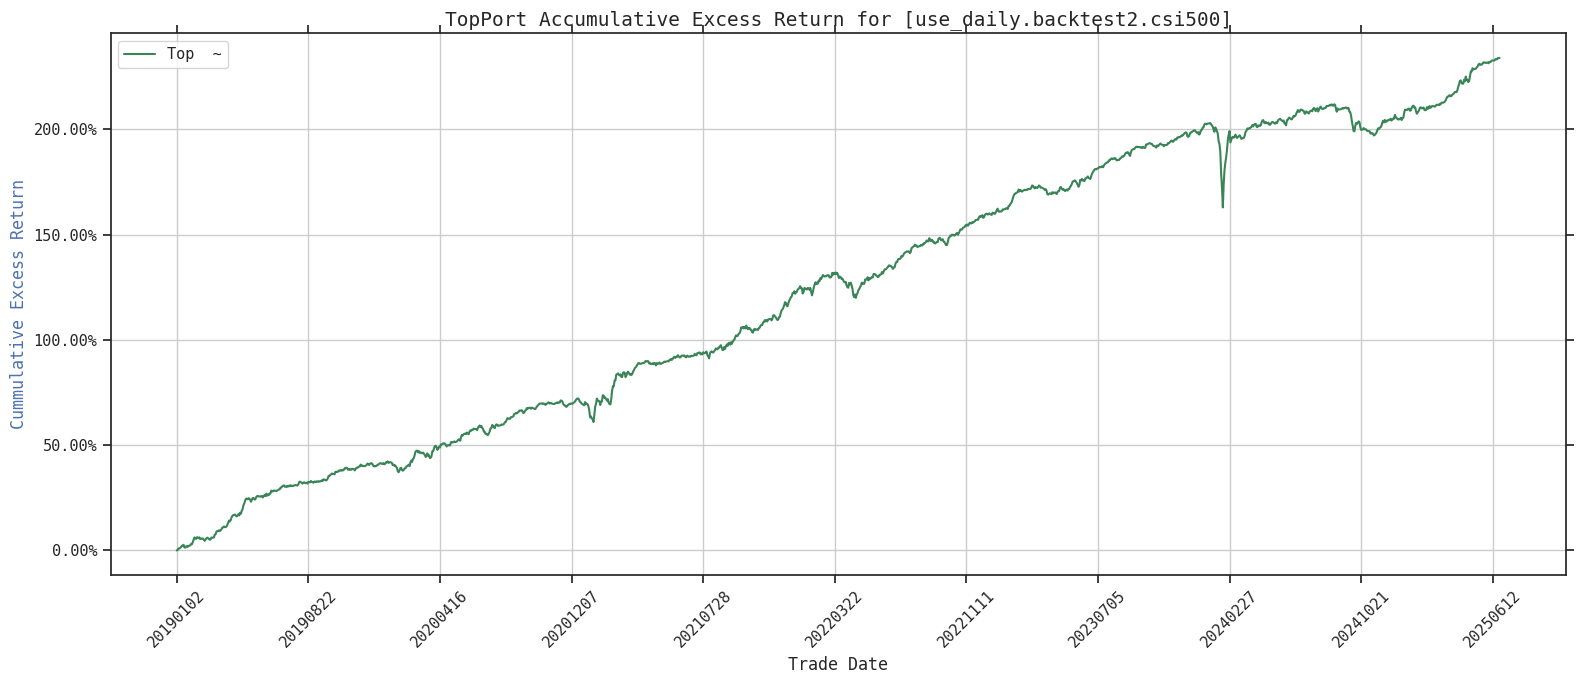

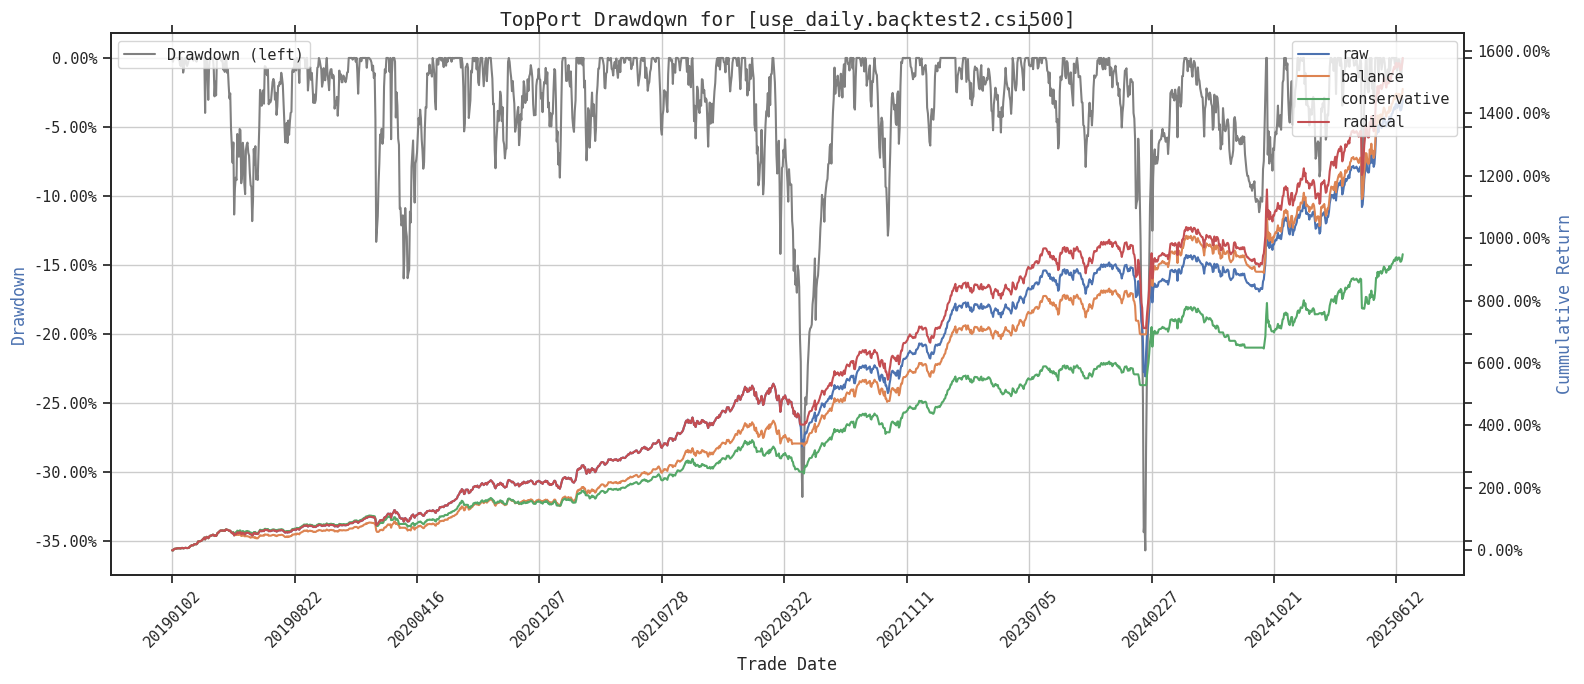

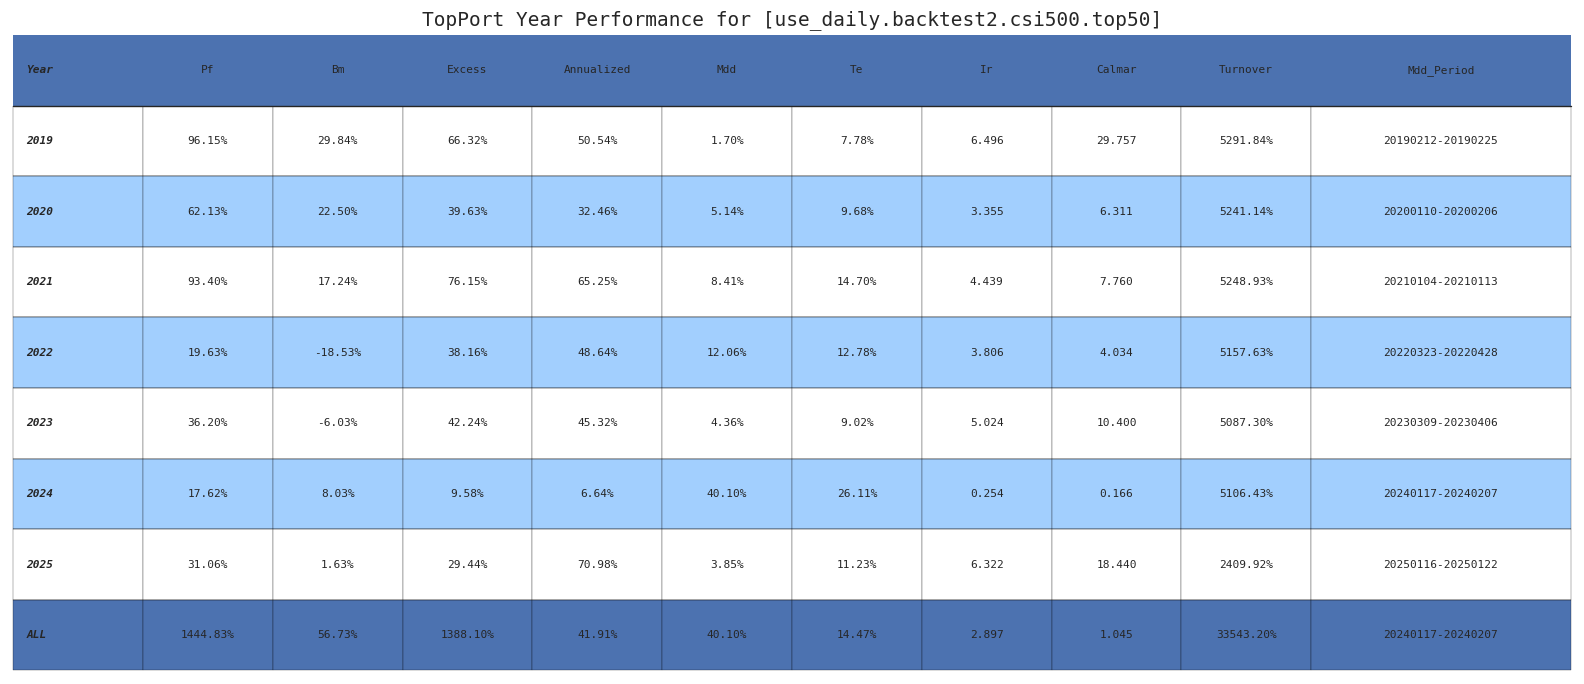

use_daily.backtest2 analyze Finished!


TradingPort(name='use_daily.backtest2', alpha='big_combine', universe='top-1000', components=['sellside@huatai.master_combined@master_combined', 'sellside@dongfang.scores_v0@avg', 'gru_day_V1'], weights=[1.0, 1.0, 1.0], top_num=50, freq=1, init_value=1000000.0, backtest=True, test_start=20190101, test_end=20991231, benchmark='csi500', buffer_zone=0.9, no_zone=0.5, indus_control=0.1)

In [ ]:
from src.res.trading.util import TradingPort
tp = TradingPort.load('use_daily.backtest2')
tp.build(20250624).analyze()

Perform backtest for TradingPort use_daily.backtest3 , 1569 days


/home/mengkjin/workspace/learndl/src/func/transform.py:161: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-32.344491958618164' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  if v2 is not None: v[v > v2] = v2
/home/mengkjin/workspace/learndl/src/func/transform.py:161: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-33.34072685241699' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  if v2 is not None: v[v > v2] = v2
/home/mengkjin/workspace/learndl/src/func/transform.py:161: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-32.38722801208496' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  if v2 is not None: v[v > v2] = 

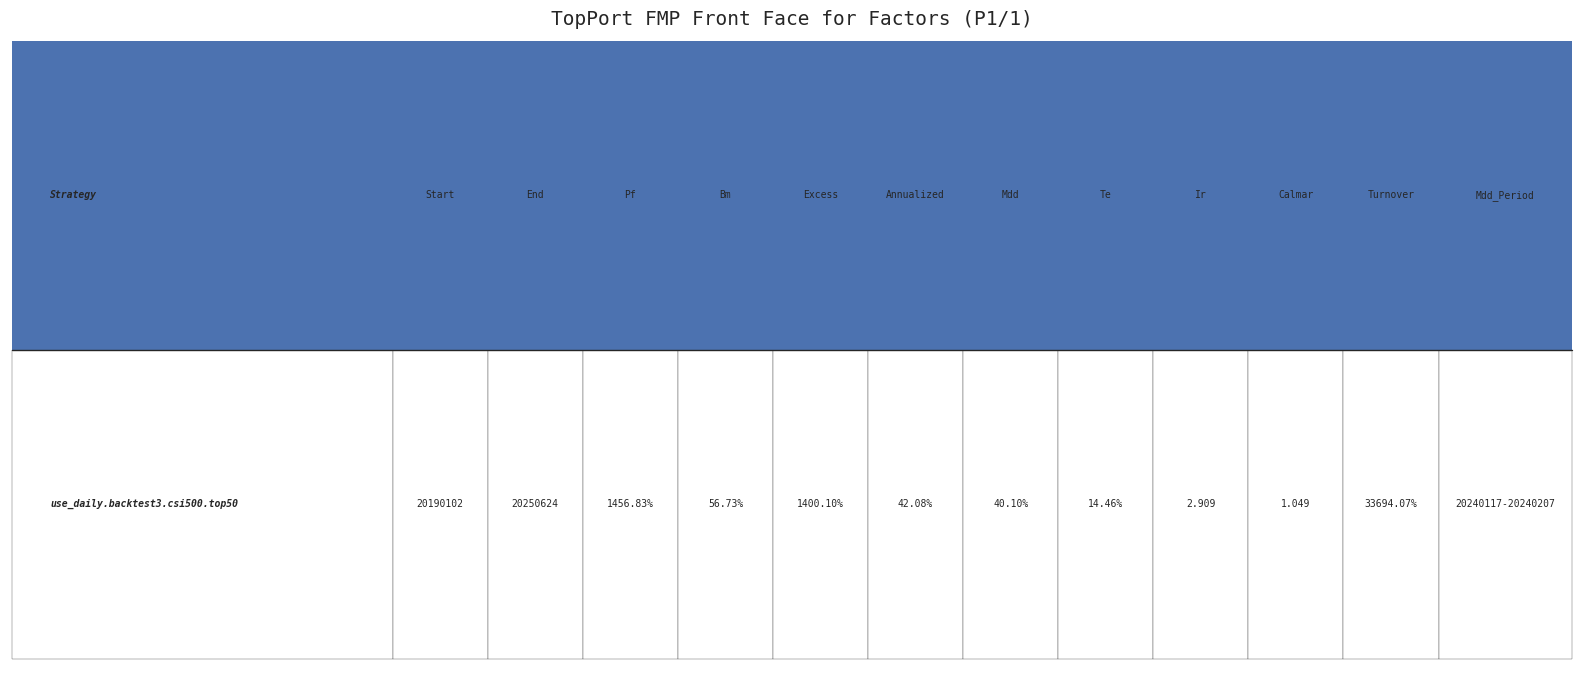

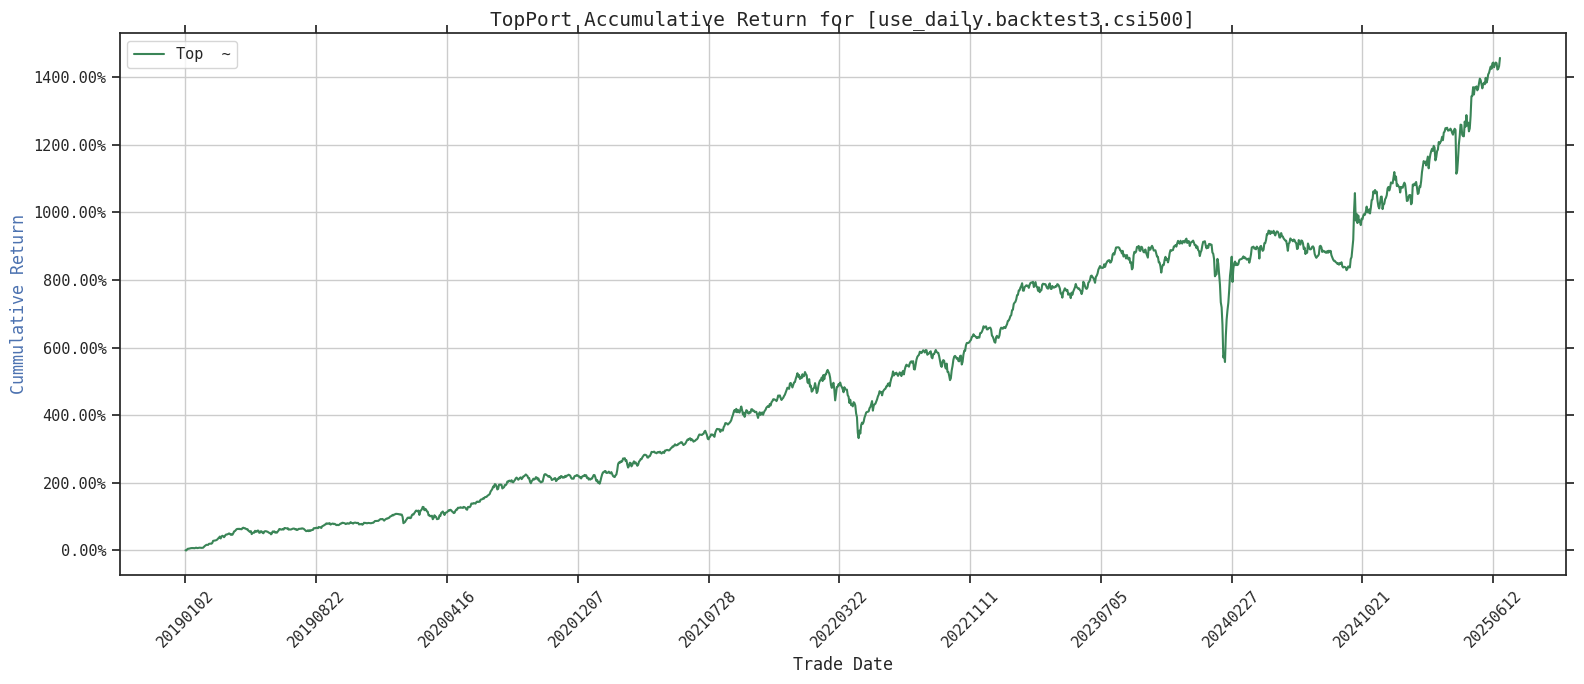

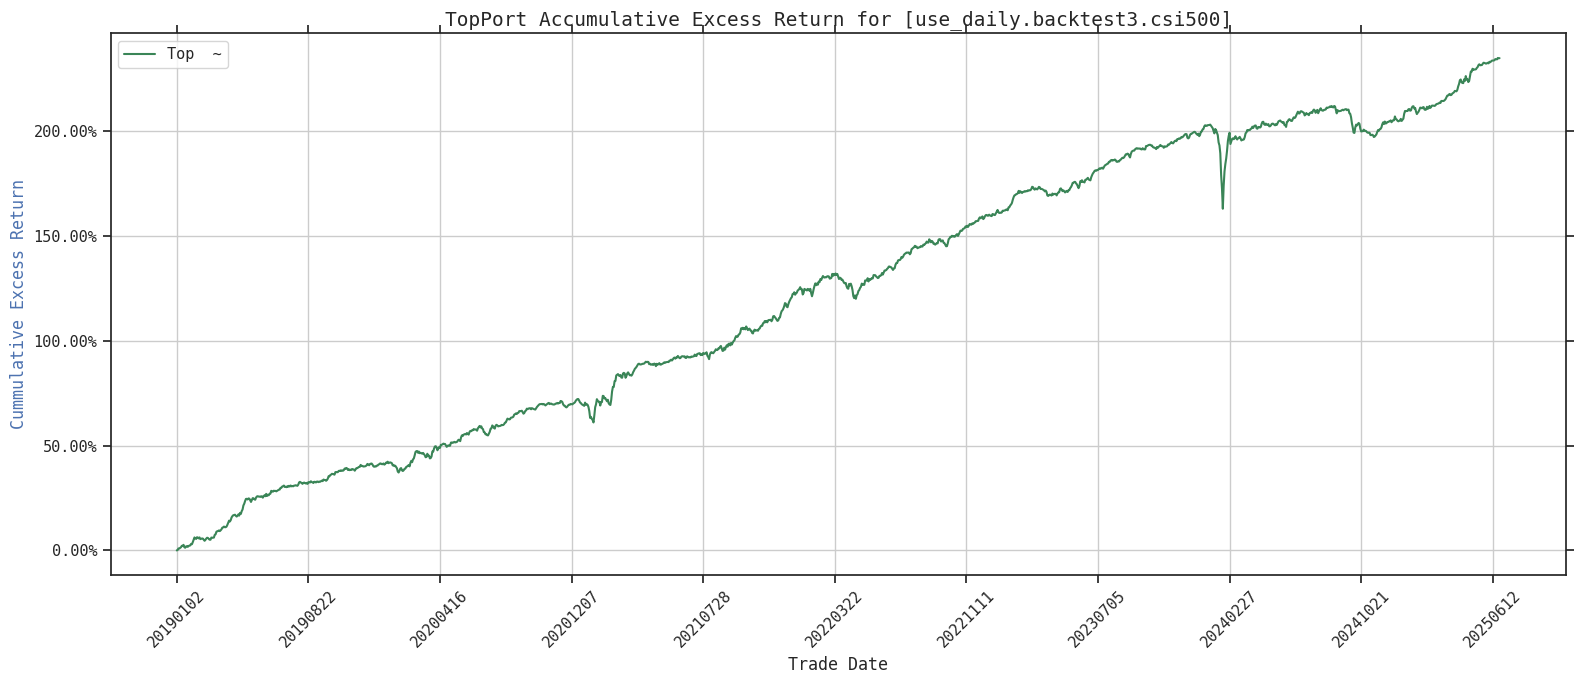

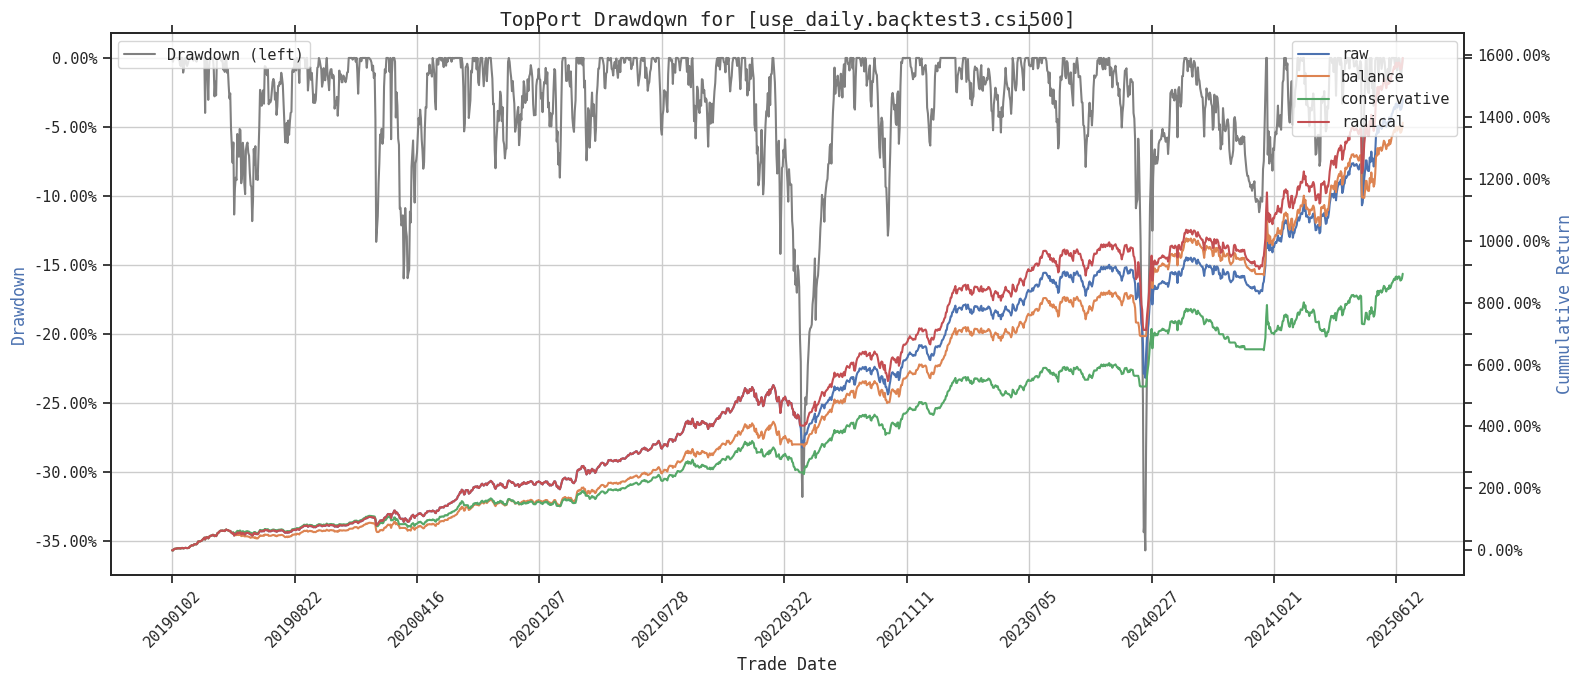

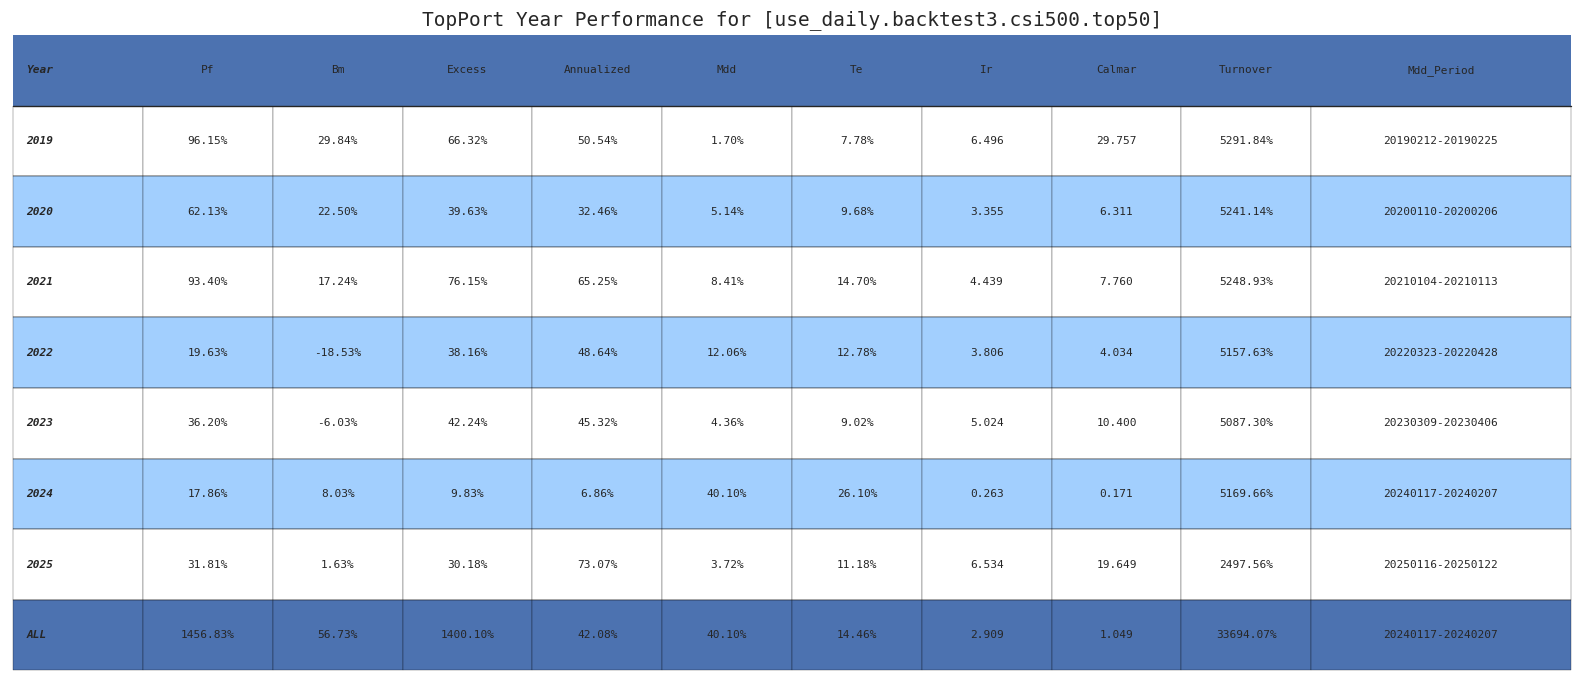

use_daily.backtest3 analyze Finished!


TradingPort(name='use_daily.backtest3', alpha='big_combine', universe='top-1000', components=['sellside@huatai.master_combined@master_combined', 'sellside@dongfang.scores_v0@avg', 'gru_day_V1'], weights=[1.0, 1.0, 1.0], top_num=50, freq=1, init_value=1000000.0, backtest=True, test_start=20190101, test_end=20991231, benchmark='csi500', buffer_zone=0.95, no_zone=0.5, indus_control=0.1)

In [ ]:
from src.res.trading.util import TradingPort
tp = TradingPort.load('use_daily.backtest3')
tp.build(20250624).analyze()

main path: /Users/mengkjin/workspace/learndl
src.INSTANCE_RECORD can be accessed to check ['trainer', 'account', 'factor']


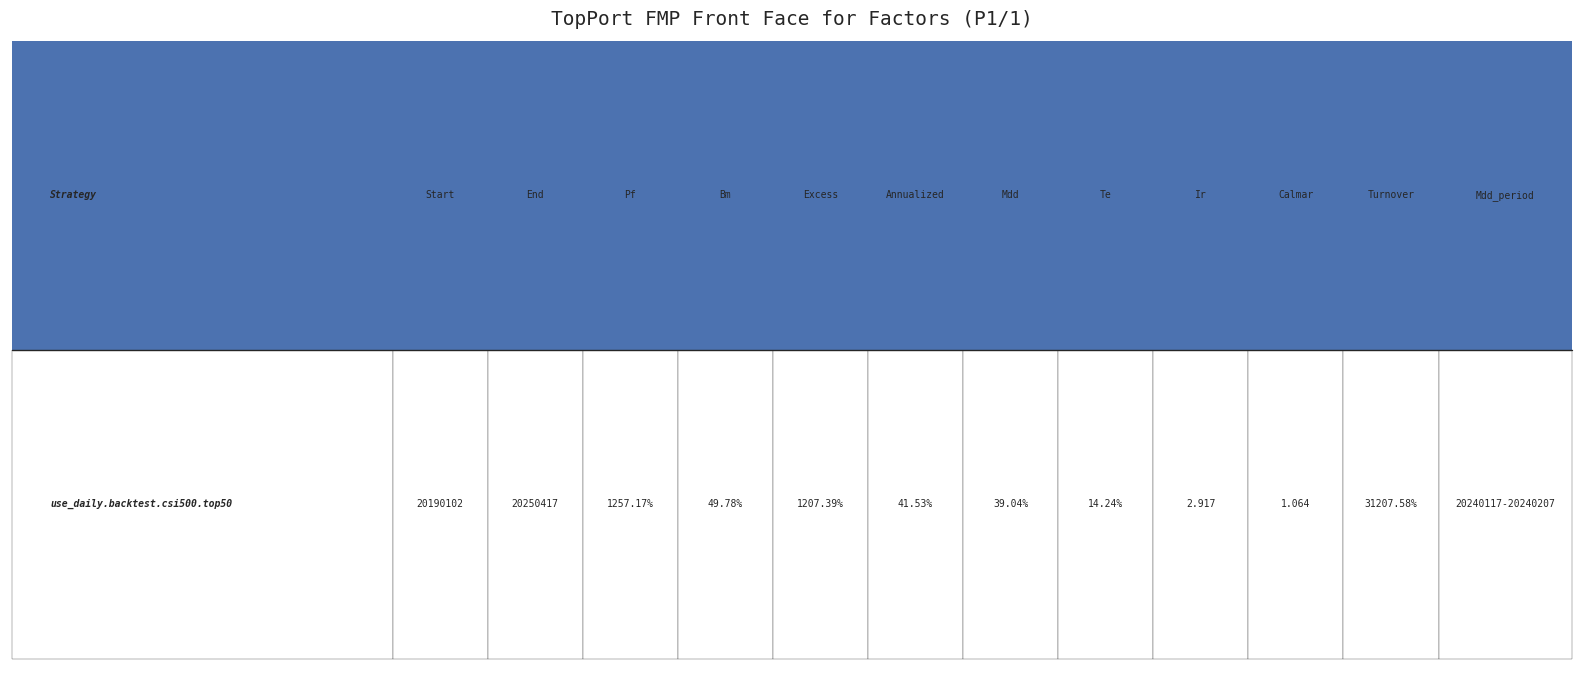

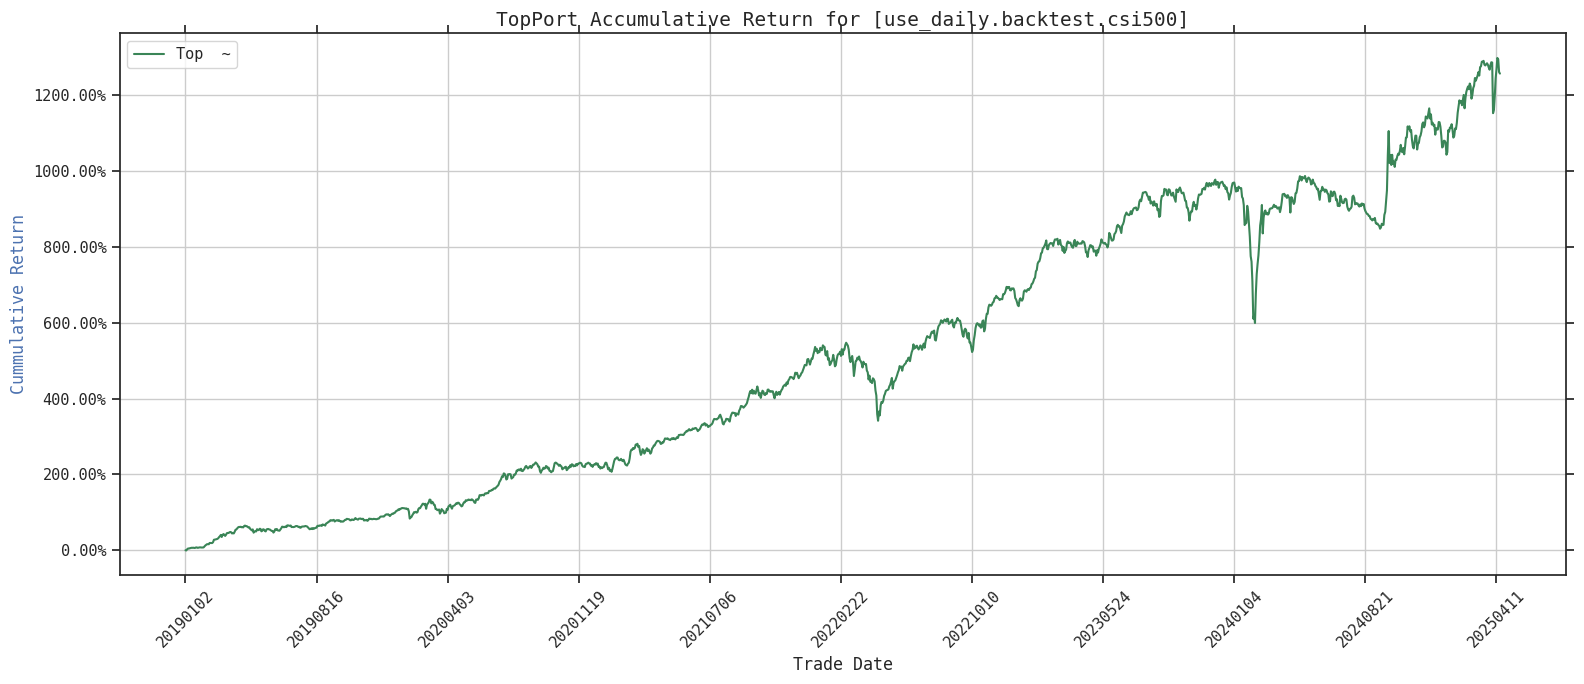

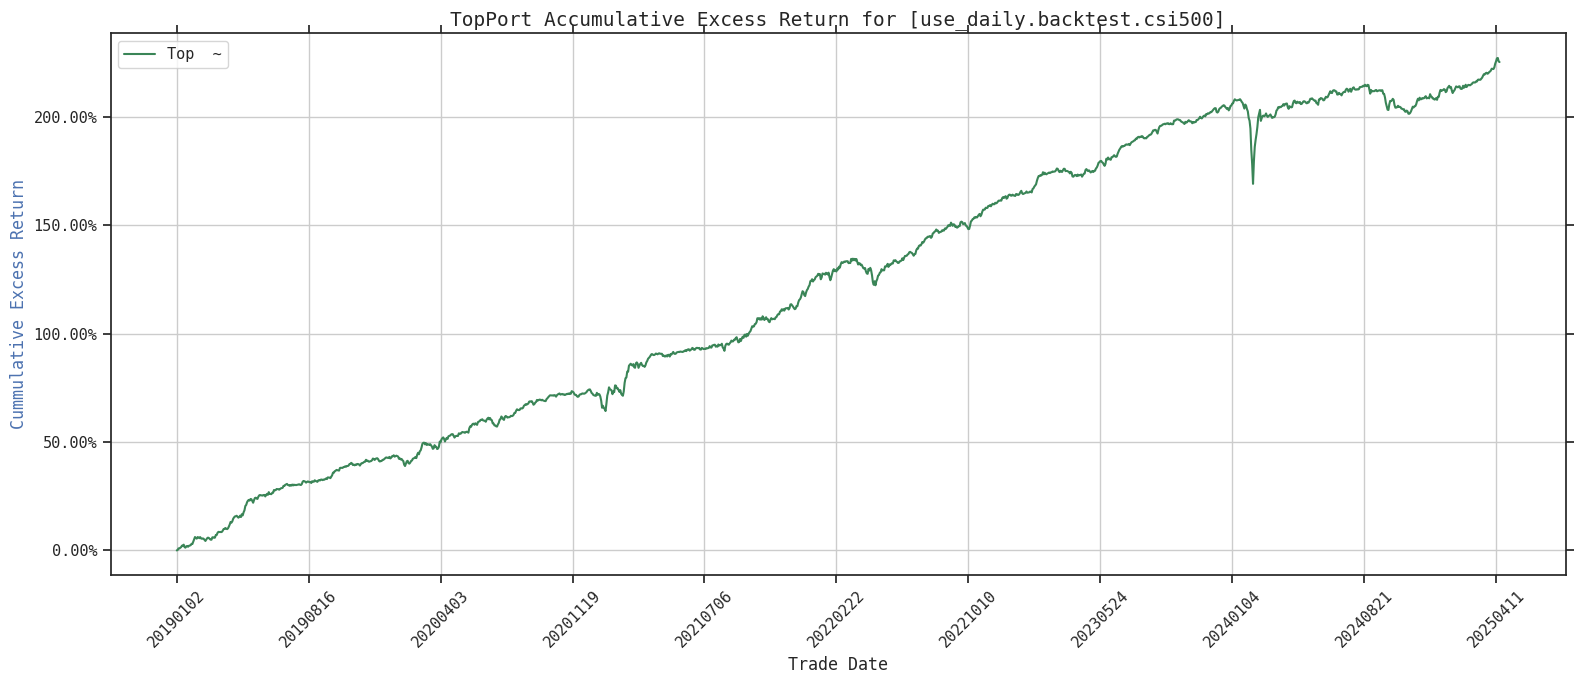

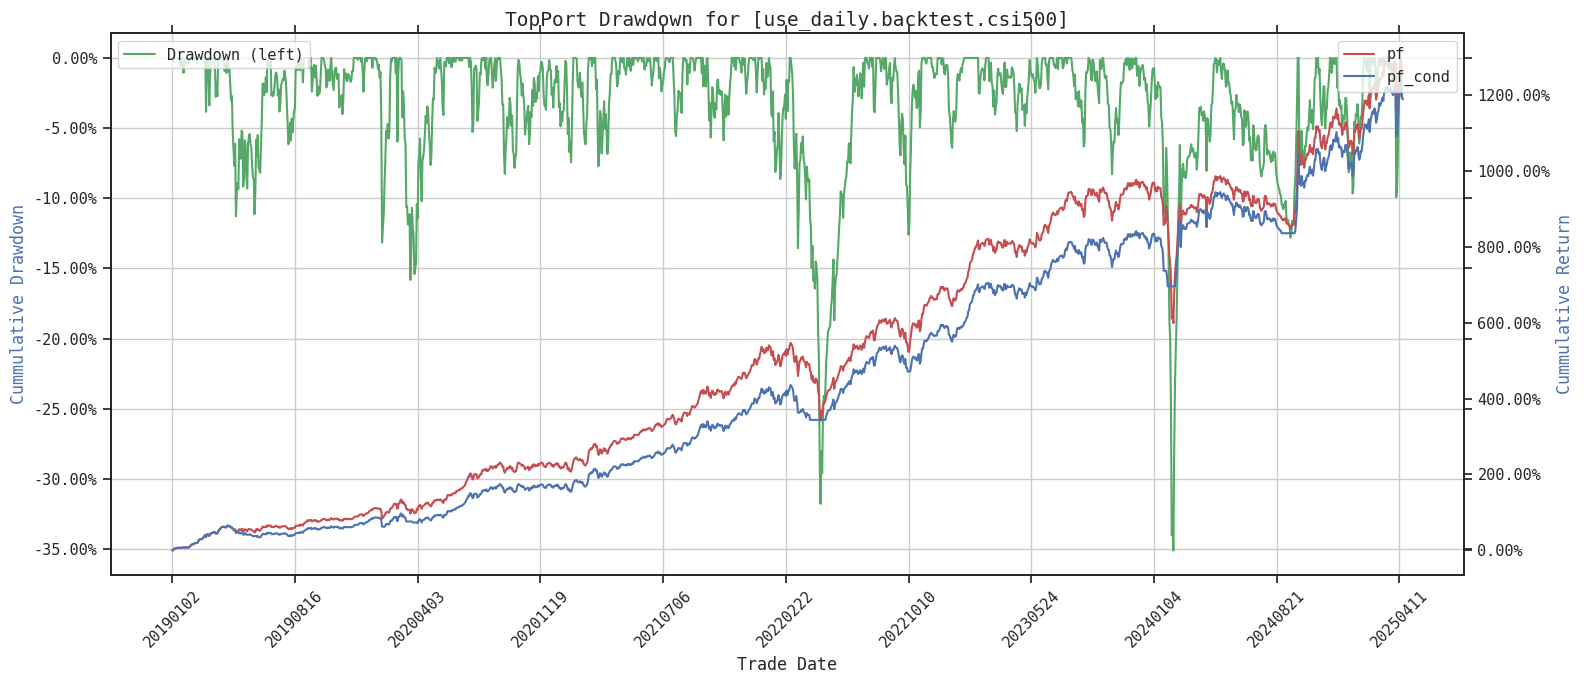

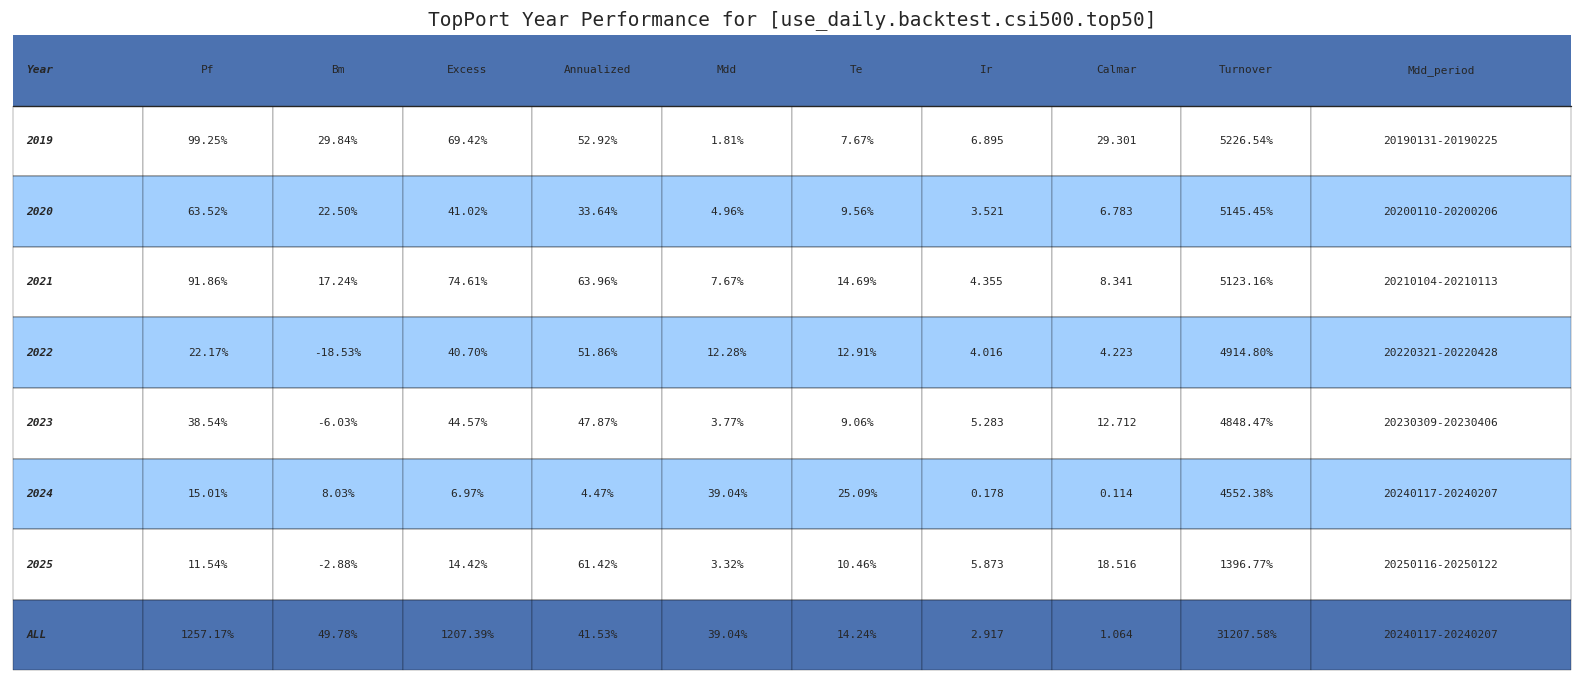

use_daily.backtest analyze Finished!


TradingPort(name='use_daily.backtest', alpha='big_combine', universe='top-1000', components=['sellside@huatai.master_combined@master_combined', 'sellside@dongfang.scores_v0@avg', 'gru_day_V1'], weights=[1.0, 1.0, 1.0], top_num=50, freq=1, init_value=1000000.0, backtest=True, test_start=20190101, test_end=20250430, benchmark='csi500')

In [ ]:
from src.res.trading.util import TradingPort
tp = TradingPort.load('use_daily.backtest')
tp.analyze(trade_engine='yale')